# Pegasos SVM implementations from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.datasets.samples_generator import make_blobs

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Pegasos algorithm

### Make synthetic dataset

We will make a synthetic dataset using scikit-learn to ensure we have a decent dataset to work with. SVMs is about finding the best hyperplane that separates data. We see below that there are a possible hyperplanes - but how do we find the best hyperplane. We need to find the best hyperplane such that we maximise the margins.

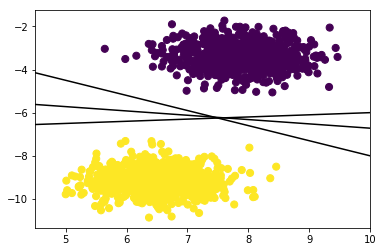

In [2]:
X, y = make_blobs(
    n_samples=1500,
    centers=2,
    random_state=6,
    cluster_std=0.6
)
y = y[:, None]
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=50);

xfit = np.linspace(4.5, 10)

for m, b in [(-0.7, -1), (-0.2, -4.72), (0.1, -7)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(4.5, 10);

### Setup

We set up our loss function, and initialize our parameters. There are many different ways to optimize SVMs such as primal/dual optimization. These can be solved using quadtratic programming methods. However, we can also use gradient descent to solve this. Typically we have a loss function that is not differential in Hinge Loss. But we can turn this problem into a sub-gradient descent and solve using gradient descent.

In [3]:
X = np.hstack([X, np.ones((X.shape[0], 1))])

In [4]:
y = np.where(y == 0, -1, y)

Split into train test set

In [5]:
train_idxs = np.random.choice(X.shape[0], 1000)
test_idxs = np.setdiff1d(np.arange(X.shape[0]), train_idxs)
X_tr = X[train_idxs]
y_tr = y[train_idxs]
X_te = X[test_idxs]
y_te = y[test_idxs]

Helper functions

In [6]:
def predict(X, w):
    return np.dot(X, w)

def svm_preds(y_preds):
    return np.where(y_preds >= 0, 1, -1)

def accuracy(y, y_preds):
    return (y == y_preds).sum() / y.shape[0]

### Train binary SVM

Using SGD

In [7]:
n_samples = X_tr.shape[0]
w = np.zeros((X_tr.shape[1],1)) # n_features x n_classes
batch_size = 1
lam = 0.01
losses = []
train_accs = []
test_accs = []
epochs = 100
for epoch in range(1, epochs+1):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_s = X_tr[batch_idxs]
    y_s = y_tr[batch_idxs]
    lr = 1 / (lam * epoch)
    # Predict
    score = predict(X_s, w)
    # Calculate loss
    loss = np.maximum(0, 1 - y_s * score)
    train_preds = svm_preds(predict(X_tr, w))
    train_acc = accuracy(y_tr, train_preds)
    test_preds = svm_preds(predict(X_te, w))
    test_acc = accuracy(y_te, test_preds)
    # Calculate gradient
    dW = 0 if loss == 0 else (y_s * X_s).T
    # Update rule
    w = ((1 - (lr * lam)) * w) + lr * dW
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        print(f"epoch={epoch}/{epochs}, train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")
    losses.append(loss.flatten())

epoch=10/100, train_acc=1.0000, test_acc=1.0000
epoch=20/100, train_acc=1.0000, test_acc=1.0000
epoch=30/100, train_acc=1.0000, test_acc=1.0000
epoch=40/100, train_acc=1.0000, test_acc=1.0000
epoch=50/100, train_acc=1.0000, test_acc=1.0000
epoch=60/100, train_acc=1.0000, test_acc=1.0000
epoch=70/100, train_acc=1.0000, test_acc=1.0000
epoch=80/100, train_acc=1.0000, test_acc=1.0000
epoch=90/100, train_acc=1.0000, test_acc=1.0000
epoch=100/100, train_acc=1.0000, test_acc=1.0000


In [8]:
train_preds = svm_preds(predict(X_tr, w))
test_preds = svm_preds(predict(X_te, w))

In [9]:
print(accuracy(y_tr, train_preds))
print(accuracy(y_te, test_preds))

1.0
1.0


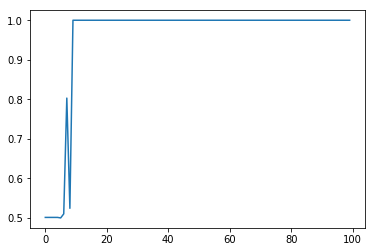

In [10]:
plt.plot(test_accs)

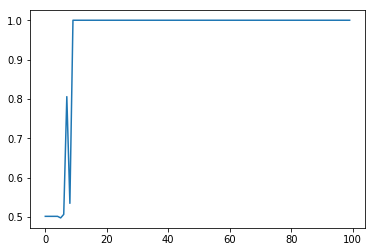

In [11]:
plt.plot(train_accs)

Using Minibatch SGD

In [23]:
def hinge_loss(y, y_pred, w, lam=0.01):
    ind_fn = y * y_pred
    n_b = y.shape[0]
    loss = np.maximum(0, 1 - ind_fn)
    loss = (loss.sum() / n_b) + (0.5 * lam * np.sum(w * w))
    return loss, ind_fn

In [27]:
n_samples = X_tr.shape[0]
w = np.zeros((X_tr.shape[1],1)) # n_features x n_classes
batch_size = 32
lam = 0.01
train_loss_history = []
test_loss_history = []
train_accs = []
test_accs = []
epochs = 100
for epoch in range(1, epochs+1):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_s = X_tr[batch_idxs]
    y_s = y_tr[batch_idxs]
    lr = 1 / (lam * epoch)
    # Predict
    score = predict(X_s, w)
    # Calculate loss
    # ind_fn = y_s * score
    n_b = X_s.shape[0]
    # loss = np.maximum(0, 1 - ind_fn)
    # loss = loss.sum() / n_b + 0.5 * lam * np.sum(w * w)
    loss, ind_fn = hinge_loss(y_s, score, w, lam=lam)
    test_loss, _ = hinge_loss(y_te, predict(X_te, w), w, lam=lam)
    # Calculate accuracy
    train_preds = svm_preds(predict(X_tr, w))
    train_acc = accuracy(y_tr, train_preds)
    test_preds = svm_preds(predict(X_te, w))
    test_acc = accuracy(y_te, test_preds)
    # The set that meets the indicator function criteria
    mask = np.zeros_like(ind_fn)
    mask[ind_fn < 1] = 1
    # Calculate gradient
    dW = np.dot((y_s * X_s).T, mask) / n_b
    # Update rule
    w = ((1 - (lr * lam)) * w) + lr * dW
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss_history.append(loss)
    test_loss_history.append(test_loss)
    if epoch % 1 == 0:
        print(f"epoch={epoch}/{epochs}, train_loss={loss:.4f}, test_loss={test_loss}, "
              f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}"
        )
    losses.append(loss.flatten())

epoch=1/100, train_loss=1.0000, test_loss=1.0, train_acc=0.5020, test_acc=0.5006
epoch=2/100, train_loss=732.7873, test_loss=727.5587801317372, train_acc=0.5020, test_acc=0.5006
epoch=3/100, train_loss=790.9330, test_loss=728.9201547414565, train_acc=0.4980, test_acc=0.4994
epoch=4/100, train_loss=472.5358, test_loss=429.32555851244774, train_acc=0.5020, test_acc=0.5006
epoch=5/100, train_loss=158.6555, test_loss=156.5685901642954, train_acc=0.8540, test_acc=0.8387
epoch=6/100, train_loss=100.9222, test_loss=100.92223360465668, train_acc=1.0000, test_acc=1.0000
epoch=7/100, train_loss=70.0849, test_loss=70.08488444767826, train_acc=1.0000, test_acc=1.0000
epoch=8/100, train_loss=51.4909, test_loss=51.490935512579945, train_acc=1.0000, test_acc=1.0000
epoch=9/100, train_loss=39.4227, test_loss=39.422747501819025, train_acc=1.0000, test_acc=1.0000
epoch=10/100, train_loss=31.1488, test_loss=31.148837532301446, train_acc=1.0000, test_acc=1.0000
epoch=11/100, train_loss=25.2306, test_loss=

Loss evaluation

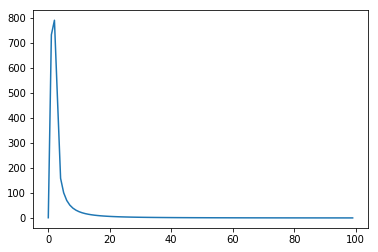

In [28]:
plt.plot(train_loss_history)

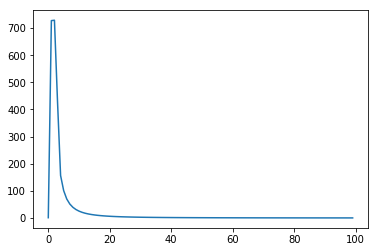

In [29]:
plt.plot(test_loss_history)

Accuracy

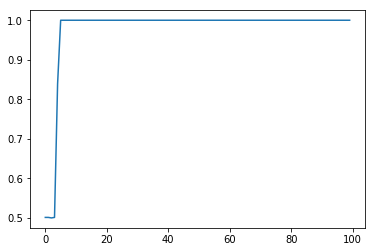

In [30]:
plt.plot(test_accs)

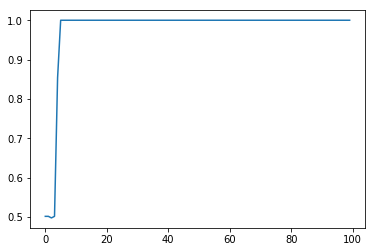

In [31]:
plt.plot(train_accs)